# SkipGram from scratch

In this notebook we implement the Skip-Gram model from scratch using Pytorch and the we use the learned embeddings to solve a classification downstream task. The goal is not to have the best performing model but to learn how to implement from scratches a skipgram model. In this direction, we use the simples implementation of skipgram.

In [11]:
# import libraries
import torch
import nltk
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from typing import List, Callable
from tqdm.notebook import tqdm
from torch import nn
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from datasets import load_dataset
import re

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/omar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# black formatting with jupyter-black
import jupyter_black

jupyter_black.load(
    lab=True,
    line_length=140,
)

# Load Dataset

As training dataset we will use the IMDB dataset

In [10]:
# load imdb dataset from hugginface
dataset = load_dataset("imdb", split="unsupervised").to_pandas()
dataset.head()

,text,label
0,This is just a precious little diamond. The pl...,-1
1,When I say this is my favourite film of all ti...,-1
2,I saw this movie because I am a huge fan of th...,-1
3,Being that the only foreign films I usually li...,-1
4,After seeing Point of No Return (a great movie...,-1


# Preprocessing

In [17]:
# Remove empty strings
dataset = dataset.dropna(subset=["text"]).query("text not in ['', ' ']")
dataset.head()

,text,label
0,This is just a precious little diamond. The pl...,-1
1,When I say this is my favourite film of all ti...,-1
2,I saw this movie because I am a huge fan of th...,-1
3,Being that the only foreign films I usually li...,-1
4,After seeing Point of No Return (a great movie...,-1


Now we create a function to process the text. The function will do a basic text normalization

In [20]:
# define normalization function
def preprocess_text(text: str):

    # to lower
    text = text.lower()

    # remove urls
    text = re.sub(r"http\S+", "", text)

    # remove html tags
    text = re.sub(r"<.*?>", "", text)

    # remove punctuation
    text = re.sub(r"[^\w\s]", "", text)

    # remove extra spaces
    text = re.sub(r"\s+", " ", text)

    return text


# apply text normalization
dataset.text = dataset.text.apply(preprocess_text)

# Tokenization


As tokenizer, we will use a simple [White Space Tokenization](https://towardsdatascience.com/5-simple-ways-to-tokenize-text-in-python-92c6804edfc4) strategy

In [22]:
# Define withe space tokenizer
def white_space_tokenizer(text):

    return text.split()

# Lang class

Now we create a class called `Lang` that will help us to convert input words to numbers 

In [6]:
class Lang:
    def __init__(self, tokenizer: Callable):
        self.word2index = {"<pad>": 0, "<ukn>": 1}
        self.word2count = {}
        self.index2word = {0: "<pad>", 1: "<ukn>"}
        self.n_words = 2  # Counts
        self.tokenizer = tokenizer

    def addSentence(self, sentence: str):
        for word in self.tokenizer(sentence):
            self.addWord(word)

    def addWord(self, word: str):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def fit(self, dataset: List[str]):

        for data in tqdm(dataset):
            self.addSentence(data)

    def transform(self, text: str):

        tokens = self.tokenizer(text)
        encoding = [self.word2index[tk] if tk in self.word2index.keys() else 1 for tk in tokens]

        return encoding[0]

    def inverse_transform(self, tokens: List[int]):

        words = [self.index2word[tk] for tk in tokens]

        return " ".join(words)

In [7]:
# We test that the Lang class is working as expected
lang = Lang(white_space_tokenizer)
lang.fit(dataset.text_column)
lang.transform("study")

  0%|          | 0/25000 [00:00<?, ?it/s]

3179

# Define Dataloader

We create a custom dataset to train the skipgram model. We use the `Lang` class and the `white_space_tokenizer` to create the custom dataset.

In [8]:
class CustomDataSet(torch.utils.data.Dataset):
    def __init__(self, text: List[str], tokenizer: Callable, window_size: int = 2) -> None:
        super().__init__()

        self.word_pairs = self.get_word_pairs(text, window_size, tokenizer)

        self.lang = Lang(tokenizer)
        self.lang.fit(text)

    def __len__(self):

        return len(self.word_pairs)

    def __getitem__(self, idx):

        x = self.lang.transform(self.word_pairs["input"].tolist()[idx])
        y = self.lang.transform(self.word_pairs["target"].tolist()[idx])

        return x, y

    def get_word_pairs(self, text: List[str], window_size: int, tokenizer: Callable):

        x = []
        y = []

        for sentence in text:

            sentence = tokenizer(sentence)

            for i in range(window_size, len(sentence) - window_size):

                words = sentence[i - window_size : i + window_size + 1]
                context = words[window_size]
                words.pop(window_size)

                for w in words:
                    x.append(context)
                    y.append(w)

        return pd.DataFrame({"input": x, "target": y}).sample(frac=1)

In [9]:
# Test Dataset and DataLoader
ds = CustomDataSet(text=sample, tokenizer=white_space_tokenizer)
loader = torch.utils.data.DataLoader(ds, batch_size=4, shuffle=True)
x, y = next(iter(loader))
x, y

  0%|          | 0/2 [00:00<?, ?it/s]

(tensor([80, 74, 82, 53]), tensor([68, 73, 83,  2]))

# SkipGram Model

Now we use Pytorch to implement a skip-gram model from scratch. There exist more sophisticated implementations of skip-gram which uses [negative sampling](https://naturale0.github.io/2021/02/08/understanding-skip-gram) and word [sub-sampling](https://naturale0.github.io/2021/02/08/understanding-skip-gram) to seep up the training process. However, in this notebook we use the most basic implementation of skip-gram.

In [34]:
class SkipGramModel(nn.Module):
    def __init__(self, embedding_dim: int, vocab_size: int, lang: Lang) -> None:
        super().__init__()

        self.lang = lang

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim, bias=False),
            nn.ReLU(),
            nn.Linear(embedding_dim, vocab_size, bias=False),
        )

    def forward(self, x):

        x = self.embeddings(x)
        x = self.fc(x)

        return x

    def config_model(self, device: str = "cuda"):

        # Define model device
        self.device = device

        # Define loss function
        self.loss = nn.CrossEntropyLoss()

        # Define optimizer
        self.optimizer = torch.optim.Adam(self.parameters())

        # send model to device
        self.to(device)

    def train_on_epoch(self, train_loader: DataLoader):

        running_loss = 0

        bar = tqdm(train_loader, leave=False)

        for step, (x, y) in enumerate(bar, 1):

            self.optimizer.zero_grad()

            # set device
            x, y = x.to(self.device), y.to(self.device)

            # logit prediction
            output = self(x)

            # compute loss
            loss = self.loss(output, y)

            # compute gradients
            loss.backward()

            # update network eights
            self.optimizer.step()

            running_loss += loss.item()

            bar.set_description(f"Train Loss: {round(running_loss/step, 2)}")

        return round(running_loss / step, 3)

    def fit(self, train_loader: DataLoader, epochs: int = 1):

        bar = tqdm(range(1, epochs + 1), desc="Epoch 1")

        for epoch in bar:

            train_loss = self.train_on_epoch(train_loader)

            bar.set_description(f"Epoch {epoch}: Train Loss: {train_loss}")

    def transform_word(self, text: List[str]):

        embedding = []

        self.eval()
        self.to(self.device)

        with torch.no_grad():

            for word in text:
                text = torch.Tensor([self.lang.transform(word)]).long().to(self.device)
                embedding.append(self.embeddings(text).flatten().cpu().numpy())

        return np.array(embedding)

    def transform_sentence(self, text: List[str]):

        embeddings = []

        for sentence in text:

            word_embedding = self.transform_word(self.lang.tokenizer(sentence))
            embeddings.append(word_embedding.mean(axis=0))

        return np.array(embeddings)

    def plot_pca_components(self, text: str, n: int = 10):

        tokens = random.sample(self.lang.tokenizer(text), n)
        embeddings = self.transform_word(tokens)

        pca = Pipeline(
            [
                ("scale", StandardScaler()),
                ("pca", PCA(n_components=2)),
            ]
        )

        x_pca = pca.fit_transform(embeddings)

        plt.plot(x_pca[:, 0], x_pca[:, 1], "o")

        for i, s in enumerate(tokens):

            x = x_pca[i, 0]
            y = x_pca[i, 1]
            plt.text(x, y, s)

        plt.xlabel("PC 1")
        plt.ylabel("PC 2")
        plt.title("PCA plot")

# Train Skip-Gram model

We train the skip-gram model using a small sample.

In [11]:
# Define data to pre-train the skip-gram model
sample = dataset.text_column.sample(300).tolist()

# Define dataset
ds_train = CustomDataSet(text=sample, tokenizer=white_space_tokenizer, window_size=2)

# Define Dataloader
train_loader = torch.utils.data.DataLoader(ds_train, batch_size=512, shuffle=True, num_workers=6)

  0%|          | 0/300 [00:00<?, ?it/s]

In [12]:
# Set vocab size
vocab_size = ds_train.lang.n_words
vocab_size

8806

In [13]:
# Instance skip-gram model
skipgram_model = SkipGramModel(embedding_dim=100, vocab_size=vocab_size, lang=ds_train.lang)

# Config skip-gram model
skipgram_model.config_model(device="cpu")

In [14]:
# Fit skipgram model
skipgram_model.fit(train_loader, 5)

Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

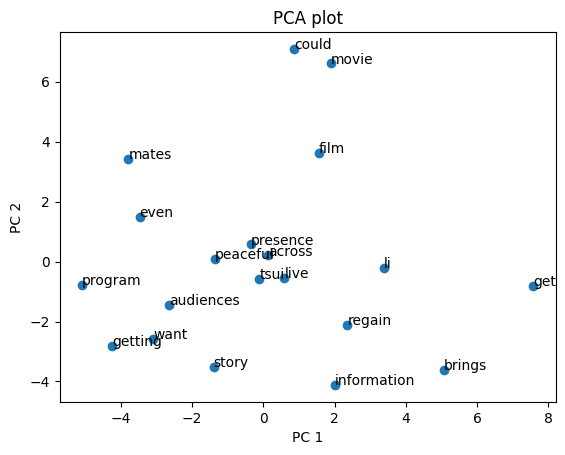

In [39]:
# Visualize embedding on 2D
skipgram_model.plot_pca_components(sample[0], n=20)

# Classification Downstream task

Finally, we use the pre-trained embeddings on a the binary classification downstream task.

In [17]:
# Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(
    dataset.text_column.tolist(), dataset.target_column.tolist(), test_size=0.1, random_state=42
)

In [18]:
# Transform input text
X_train_emb = skipgram_model.transform_sentence(X_train)
X_test_emb =skipgram_model.transform_sentence(X_test)

In [19]:
# Define classification model
model = LogisticRegression()

In [20]:
# Fit Classification model
model.fit(X_train_emb, y_train)

LogisticRegression()

In [21]:
# Model performance on the test set 
model.score(X_test_emb, y_test)

0.6856